In [1]:
import networkx as nx
import pandas as pd
import osmnx as ox

## Introduction

We're going to go through graph I/O,
specifically the APIs on how to convert
graph data that comes to you
into that magical NetworkX object `G`.

There are multiple ways of loading and reading from
disk, you can check out more docs at
https://networkx.org/documentation/latest/reference/readwrite/index.html

- DOT
- GEXF
- GraphML
- GML
- JSON
- LEDA
- Pajek
- Matrix Market
- ...

But in this notebook will be specifically look at Tabular Data.
Let's get going!

## Graph Data as Tables

Let's recall what we've learned in the introductory chapters.
Graphs can be represented using two **sets**:

- Node set
- Edge set

### Node set as tables

Let's say we had a graph with 3 nodes in it: `A, B, C`.
We could represent it in plain text, computer-readable format:

```csv
A
B
C
```

Suppose the nodes also had metadata.
Then, we could tag on metadata as well:

```csv
A, circle, 5
B, circle, 7
C, square, 9
```

Does this look familiar to you?
Yes, node sets can be stored in CSV format,
with one of the columns being node ID,
and the rest of the columns being metadata.

### Edge set as tables

If, between the nodes, we had 4 edges (this is a directed graph),
we can also represent those edges in plain text, computer-readable format:

```csv
A, C
B, C
A, B
C, A
```

And let's say we also had other metadata,
we can represent it in the same CSV format:

```csv
A, C, red
B, C, orange
A, B, yellow
C, A, green
```

If you've been in the data world for a while,
this should not look foreign to you.
Yes, edge sets can be stored in CSV format too!
Two of the columns represent the nodes involved in an edge,
and the rest of the columns represent the metadata.

## Dataset

We will look at how far away you can run away once
you see the ghost of the manor!

We will use osmnx to fetch the data from Open Street Maps.

In [2]:
G, coords = ox.graph_from_address(
    address="Dr. Holms Hotel, Geilo, Norway",
    dist=20_000,    # in meters.
    dist_type="network",
    return_coords=True
)

In [3]:
coords

(60.53597499999999, 8.207438203049048)

In [4]:
bbox_bound = ox.utils_geo.bbox_from_point(coords, dist=20_000, project_utm=True)

In [6]:
G_projected = ox.project_graph(G)

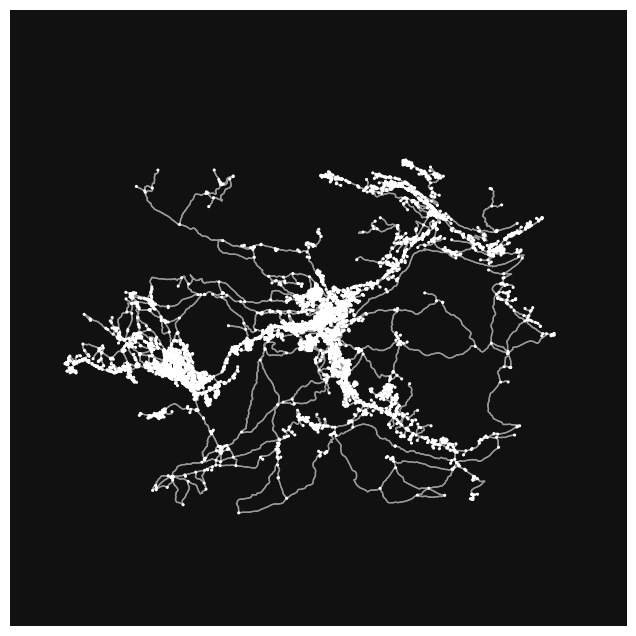

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
ox.plot_graph(G_projected, node_size=5, bbox=bbox_bound)

Let's look at the graph to see what is inside this data we just fetched.

In [10]:
list(G_projected.nodes.data())[0:2]

[(149438,
  {'y': 6720245.354885719,
   'x': 450126.5355905304,
   'street_count': 3,
   'lon': 8.088871,
   'lat': 60.6149486}),
 (6654904602,
  {'y': 6720308.769693093,
   'x': 449977.3027856056,
   'street_count': 3,
   'lon': 8.086129,
   'lat': 60.6154993})]

In [11]:
list(G_projected.edges.data())[0:2]

[(149438,
  6654904602,
  {'osmid': 122244729,
   'ref': '50',
   'name': 'Hovsvegen',
   'highway': 'primary',
   'maxspeed': '80',
   'oneway': False,
   'reversed': False,
   'length': 166.755,
   'geometry': <LINESTRING (450126.536 6720245.355, 450113.292 6720244.514, 450101.695 6720...>}),
 (149438,
  6654904547,
  {'osmid': 122244729,
   'ref': '50',
   'name': 'Hovsvegen',
   'highway': 'primary',
   'maxspeed': '80',
   'oneway': False,
   'reversed': True,
   'length': 913.764,
   'geometry': <LINESTRING (450126.536 6720245.355, 450135.124 6720246.483, 450144.384 6720...>})]

## Exercise

Find all the streets in the graph `G_projected` which have the type of `highway` as `primary`.

Hint:

This is a MultiDiGraph!!

When you iterate through the edges you would need to do somthing like:
```python
for u, v, key, ddict in G.edges(data=True, keys=True):
    ...
    ...
```


Now let's export this network to a pandas dataframe
and use dataframe operations to do the same thing!

In [12]:
streets = nx.to_pandas_edgelist(G_projected, edge_key='edge_key')

In [13]:
len(streets[streets.highway == 'primary'])

340

In [14]:
streets[streets.highway == 'primary'].head()

,source,target,edge_key,geometry,highway,bridge,maxspeed,reversed,oneway,service,length,lanes,name,ref,access,tunnel,junction,osmid
0,149438,6654904602,0,LINESTRING (450126.5355905304 6720245.35488571...,primary,NaN,80,False,False,NaN,166.755,NaN,Hovsvegen,50,NaN,NaN,NaN,122244729
1,149438,6654904547,0,LINESTRING (450126.5355905304 6720245.35488571...,primary,NaN,80,True,False,NaN,913.764,NaN,Hovsvegen,50,NaN,NaN,NaN,122244729
3,6654904602,2904381194,0,LINESTRING (449977.3027856056 6720308.76969309...,primary,NaN,80,False,False,NaN,73.029,NaN,Hovsvegen,50,NaN,NaN,NaN,122244729
4,6654904602,149438,0,LINESTRING (449977.3027856056 6720308.76969309...,primary,NaN,80,True,False,NaN,166.755,NaN,Hovsvegen,50,NaN,NaN,NaN,122244729
6,6654904547,149438,0,LINESTRING (450788.9472488364 6720766.22789174...,primary,NaN,80,False,False,NaN,913.764,NaN,Hovsvegen,50,NaN,NaN,NaN,122244729


## Exercise

Extract the primary highway streets from the dataframe and then use that
information to plot a subgraph street network with only primary highways.

In [15]:
nodes = ...

In [16]:
# ox.plot_graph(G_projected.subgraph(nodes), bbox=bbox_bound)

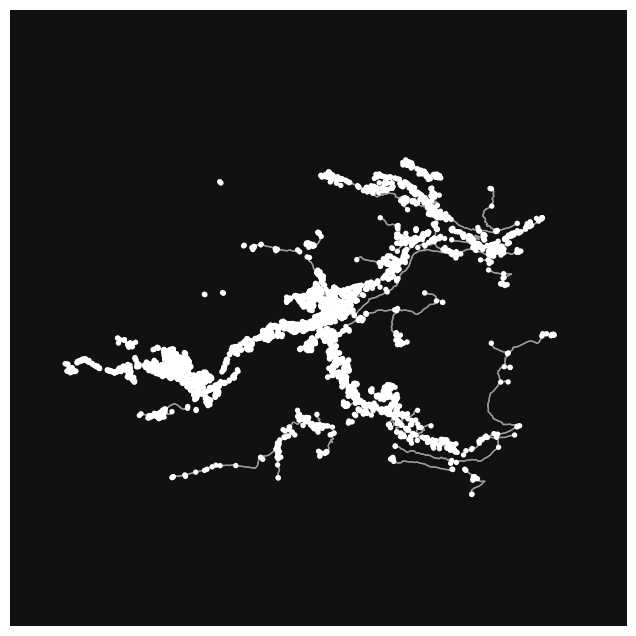

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
nodes = streets[streets.highway == 'service'][['source', 'target']].values.flatten()
ox.plot_graph(G_projected.subgraph(nodes), bbox=bbox_bound)

### But what about the node attributes??

In [18]:
list(G_projected.nodes.data())[0:5]

[(149438,
  {'y': 6720245.354885719,
   'x': 450126.5355905304,
   'street_count': 3,
   'lon': 8.088871,
   'lat': 60.6149486}),
 (6654904602,
  {'y': 6720308.769693093,
   'x': 449977.3027856056,
   'street_count': 3,
   'lon': 8.086129,
   'lat': 60.6154993}),
 (6654904547,
  {'y': 6720766.227891748,
   'x': 450788.9472488364,
   'street_count': 3,
   'lon': 8.1008406,
   'lat': 60.6197065}),
 (2904381161,
  {'y': 6720189.092637471,
   'x': 450016.38766896207,
   'street_count': 3,
   'lon': 8.0868733,
   'lat': 60.6144298}),
 (149473,
  {'y': 6716053.572321035,
   'x': 468226.56915587245,
   'street_count': 4,
   'lon': 8.4201867,
   'lat': 60.579158})]

In [19]:
df = pd.DataFrame.from_dict(
    dict(G_projected.nodes(data=True)),
    orient='index')

In [26]:
df.street_count.unique()

array([3, 4, 1, 5, 2])

<Axes: xlabel='lon', ylabel='lat'>

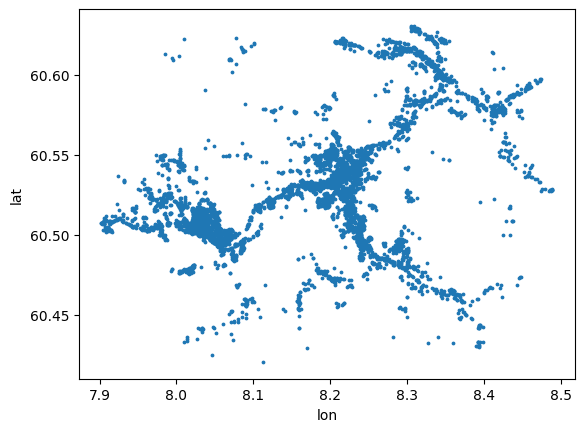

In [36]:
df.plot.scatter(x='lon', y='lat', s=3)

In [22]:
edge_centrality = nx.closeness_centrality(nx.line_graph(G_projected))
nx.set_edge_attributes(G_projected, edge_centrality, "edge_centrality")

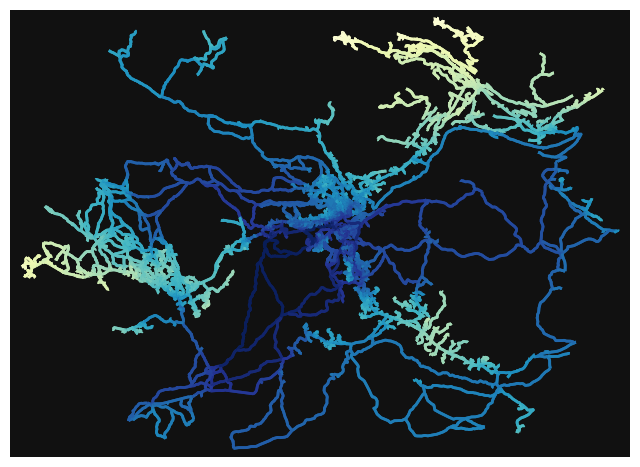

In [30]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G_projected, "edge_centrality", cmap="YlGnBu")
fig, ax = ox.plot_graph(G_projected, edge_color=ec, edge_linewidth=2, node_size=0)